# Overview of Parliamentary Papers

```{contents}
:local:
:backlinks: None
```

## What are Parliamentary Papers?

Parliamentary Papers are documents presented to the Australian Parliament. Sometimes this is required by law. Other times it's just for information. The [Parliament of Australia website notes](https://www.aph.gov.au/Parliamentary_Business/Chamber_documents/Tabled_Papers/Parliamentary_Papers_series):

> Documents presented include the annual reports of all government agencies, reports of royal commissions and other government inquiries, parliamentary committee reports, and a wide variety of other material.

As well as Trove, Parliamentary Papers can be [found through ParlInfo](https://parlinfo.aph.gov.au/parlInfo/search/summary/summary.w3p;adv=yes;orderBy=customrank;page=0;query=Dataset%3AppSeries;resCount=Default), Parliament's own online database.

Here's a few randomly selected examples:

In [2]:
import altair as alt
import pandas as pd
from IPython.display import HTML
from myst_nb import glue
from wordcloud import WordCloud

In [17]:
df = pd.read_csv(
    "https://github.com/GLAM-Workbench/trove-parliamentary-papers-data/raw/main/trove-parliamentary-papers.csv"
)

random_sample = df.sample(3)[["title", "contributor", "date", "fulltext_url"]]
random_sample["thumbnail"] = random_sample["fulltext_url"].apply(lambda x: f"{x}-t")
random_sample = random_sample[
    ["thumbnail", "title", "contributor", "date", "fulltext_url"]
]


def to_img_tag(path):
    return '<img src="' + path + '" width="50" >'


display(
    HTML(
        random_sample.to_html(
            escape=False,
            formatters={"thumbnail": to_img_tag},
            index=False,
            render_links=True,
        )
    )
)

thumbnail,title,contributor,date,fulltext_url
,"PP no. 51 of 1925|Yarns, woollen : report and recommendation, lOth September, 1925|Yarns, woollen : report and recommendation, lOth September, 1925 / Tariff Board.",Australia. Tariff Board|Australia. Tariff Board 280 7743b2ec-b86b-5480-8aed-8460efac9864,1925,https://nla.gov.au/nla.obj-2772315313
,PP no. 81 of 1991|Report of the inquiry into the death of Maxwell Roy Saunders|Report of the inquiry into the death of Maxwell Roy Saunders / Royal Commission into Aboriginal Deaths in Custody.,"Australia. Royal Commission into Aboriginal Deaths in Custody|Australia. Royal Commission into Aboriginal Deaths in Custody.|Australia. Royal Commission into Aboriginal Deaths in Custody. 44036 ec5b490c-d8fa-54b9-aabb-6b1342df4c58|Wootten, John Halden, 1922-2021.|Wootten, John Halden.",1991,https://nla.gov.au/nla.obj-1940954500
,"Managing Australia's world heritage|Managing Australia's world heritage / Parliament of the Commonwealth of Australia, House of Representatives Standing Committee on Environment, Recreation and the Arts.|PP no. 193 of 1996","Australia. Parliament. House of Representatives. Standing Committee on Environment, Recreation and the Arts|Australia. Parliament. House of Representatives. Standing Committee on Environment, Recreation and the Arts.|Australia. Parliament. House of Representatives. Standing Committee on Environment, Recreation and the Arts. 54210 a958e025-b143-5486-bcfd-562d838eb51e|Langmore, John, 1939-",1996,https://nla.gov.au/nla.obj-2324107139


In [18]:
glue("pp-total", df.shape[0], display=False)

## How many Parliamentary Papers are digitised in Trove?

Many Commonwealth Parliamentary Papers have been digitised and made available through Trove. But, because of the way they're arranged and described, it's difficult to know exactly how many there are. I've attempted to harvest details of all the Parliamentary Papers in Trove using a combination of techniques. Based on [this dataset](https://glam-workbench.net/trove-government/trove-parliamentary-papers-data/), it seems there are currently {glue:text}`pp-total:,` digitised Parliamentary Papers in Trove. Here are some more statistics from this dataset:

In [3]:
df = pd.read_csv(
    "https://github.com/GLAM-Workbench/trove-parliamentary-papers-data/raw/main/trove-parliamentary-papers.csv",
    keep_default_na=False,
)

stats = [
    ["Number of digitised Parliamentary Papers", df.shape[0]],
    ["Total number of pages", df["pages"].sum()],
    ["Median number of pages per publication", df["pages"].median()],
]

stats_df = pd.DataFrame(stats)
stats_df.style.format(thousands=",", precision=0).hide().hide(axis=1).set_properties(
    **{"text-align": "left"}
)

Number of digitised Parliamentary Papers,"24,991"
Total number of pages,"2,448,576"
Median number of pages per publication,60


Most of the Parliamentary Papers in Trove were published before 2013. If you search in ParlInfo for [Parliamentary Papers published before 2013](https://parlinfo.aph.gov.au/parlInfo/search/summary/summary.w3p;adv=yes;orderBy=customrank;page=0;query=(Date%3A%20%3E%3E%2031%2F12%2F2012)%20Dataset%3AppSeries;resCount=Default) the total number of results is 25,853 – close, but not exactly the same. There could be publications missing from Trove, or duplicates in the ParlInfo results.

## When were the Parliamentary Papers published?

The `date` metadata is not always accurate, but it seems good enough to explore the distribution of Trove's Parliamentary Papers over time.

In [20]:
import altair as alt

df["year"] = df["date"].str.extract(r"\b(\d{4})$")
years = df["year"].value_counts().to_frame().reset_index()

chart_dates = (
    alt.Chart(years)
    .mark_bar(size=3)
    .encode(
        x="year:T", y="count:Q", tooltip=[alt.Tooltip("year:T", format="%Y"), "count:Q"]
    )
    .properties(width="container")
)

display(chart_dates)

alt.Chart(...)

In [21]:
glue("chart-dates", chart_dates, display=False)

```{glue:figure} chart-dates
:name: "pp-overview-chart-dates"

Publication dates of digitised Parliamentary Papers in Trove
```

From the chart above it looks like the earliest Parliamentary Paper pre-dates the Commonwealth Parliament. What is it?

In [22]:
df["year"] = df["year"].astype("Int64")
earliest = df.loc[df["year"].idxmin()]
display(
    HTML(
        f"<a href='{earliest['fulltext_url']}'>{earliest['title']} / {earliest['alternative_title']}</a>"
    )
)

## Titles and topics of Parliamentary Papers

What are all these Parliamentary Papers about? You can use the `title`, `subject`, and `contributor` fields to explore their content.

Here, for example is a word cloud generated from the `title` field. There's a lot of annual reports, and many of the titles include the abbreviation "PP", so I've excluded the words "report", "annual", "PP", and "AR".

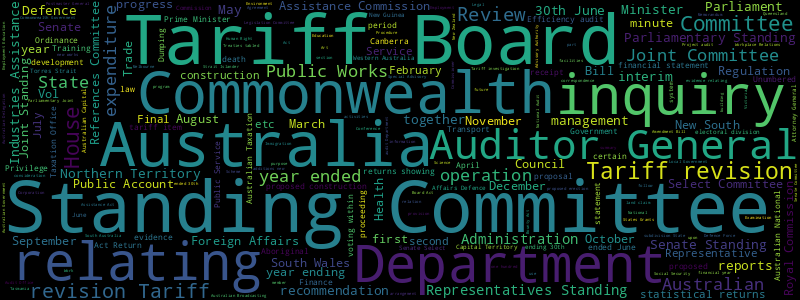

In [23]:
from wordcloud import STOPWORDS, WordCloud

# Add to the list of standard stopwords
stopwords = ["report", "annual", "pp", "AR"] + list(STOPWORDS)

titles = " ".join(df["title"].to_list())
wc = WordCloud(stopwords=stopwords, width=800, height=300)
wc.generate(titles).to_image()

The `subject` field contains a list of standard(ish) subject headings. Here's the top twenty values:

In [24]:
import re


def split_and_clean(value):
    values = value.split("|")
    return list(
        set([re.sub(r"(\w)--(\w)", r"\1 -- \2", v).strip(".") for v in values if v])
    )


df["subject"] = df["subject"].apply(split_and_clean)

subjects = df["subject"].explode().to_frame()
# Remove trailing full stops
subjects["subject"] = subjects["subject"].str.strip(".")
subjects["subject"].value_counts().to_frame().reset_index()[:20].style.format(
    thousands=","
).hide()

subject,count
Australian,"7,321"
Australia,"6,833"
Tariff -- Australia,"1,575"
"Finance, Public -- Australia -- Accounting -- Periodicals","1,568"
Federal issue,"1,265"
Administrative agencies -- Australia -- Auditing -- Periodicals,"1,165"
"Finance, Public -- Australia -- Auditing","1,150"
"Finance, Public -- Auditing","1,140"
Executive departments -- Australia -- Auditing -- Periodicals,"1,135"
Tariff Australia,"1,111"


The name of the agency that created a particular publication can also give an indication of its content. Here are the top twenty contributing organisations:

In [25]:
def clean_contributor(value):
    if cleaned := re.search(r"(.*?) [0-9]+ [0-9a-z\-]+$", str(value)):
        return cleaned.group(1).strip(".")
    else:
        return str(value).strip(".")


contributors = df["contributor"].str.split("|").explode().to_frame()
contributors["cleaned name"] = contributors["contributor"]
contributors["cleaned name"] = contributors["contributor"].apply(clean_contributor)
contributors.dropna()["cleaned name"].value_counts().to_frame().reset_index()[
    :20
].style.format(thousands=",").hide()

cleaned name,count
Australia. Tariff Board,"3,802"
Australia. Parliament,"3,284"
Australian National Audit Office,"3,111"
Australia. Parliament. Standing Committee on Public Works,"2,059"
,"1,560"
Australia. Industries Assistance Commission,"1,053"
Australia. Parliament. Joint Committee of Public Accounts,825
Australia. Parliament. issuing body,787
Australia,415
Australia. Parliament. Senate. Committee of Privileges,399
